In [1]:
#Basic Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Natural language processing libraries
from nltk.corpus import stopwords
import string 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer,word_tokenize
import re
from nltk import FreqDist
from wordcloud import WordCloud
#scikit-learn
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import label_binarize
#Evaluation metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_curve,auc,r2_score,f1_score,roc_auc_score,ConfusionMatrixDisplay
#imbalanced-learn
from imblearn.pipeline import Pipeline  # Use imbalanced-learn's Pipeline
from imblearn.over_sampling import SMOTE

# Understanding the dataset

In [2]:
data = pd.read_csv('Apple-Twitter-Sentiment-DFE.csv',encoding='latin-1')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [3]:
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [4]:
data.shape
print(f'This dataset contains {data.shape[0]} rows')
print(f'This dataset contains {data.shape[1]} columns')

This dataset contains 3886 rows
This dataset contains 2 columns


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3886 non-null   object
 1   sentiment  3886 non-null   object
dtypes: object(2)
memory usage: 60.8+ KB


In [6]:
data.isna().sum()

text         0
sentiment    0
dtype: int64

In [7]:
data.describe()

,text,sentiment
count,3886,3886
unique,3219,4
top,"RT @OneRepublic: Studio at 45,000 ft. One out...",3
freq,304,2162


## Data cleaning

In [8]:
data[data.duplicated()]

,text,sentiment
32,RT @thehill: Justice Department cites 18th cen...,3
34,RT @thehill: Justice Department cites 18th cen...,3
38,RT @thehill: Justice Department cites 18th cen...,3
42,RT @thehill: Justice Department cites 18th cen...,3
45,RT @thehill: Justice Department cites 18th cen...,3
...,...,...
3846,RT @TeamCavuto: Protesters stage #DieIn protes...,3
3852,RT @TeamCavuto: Protesters stage #DieIn protes...,3
3855,RT @Ecofantasy: Thinking of upgrading to #Yose...,1
3878,RT @shannonmmiller: Love the @Apple is support...,5


In [9]:
data.drop_duplicates(inplace=True)

In [10]:
data['sentiment'].value_counts()

sentiment
3               1681
1               1102
5                379
not_relevant      81
Name: count, dtype: int64

In [11]:
#drop the not_relevant label
data = data.query('~(sentiment=="not_relevant")') #data = data.query('sentiment !="not_relevant"')
#confirm sentiment 'not_relevant' has been removed
data['sentiment'].value_counts()

sentiment
3    1681
1    1102
5     379
Name: count, dtype: int64

In [12]:
data['sentiment'] = data['sentiment'].astype(int)
#confirm removal using info method
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3162 entries, 0 to 3884
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3162 non-null   object
 1   sentiment  3162 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.1+ KB


## Preprocess text

In [13]:
def clean_text(text):
    stopword_list = stopwords.words('english')
    stopword_list += string.punctuation
    lemmatizer = WordNetLemmatizer()
    
    #remove hyperlinks,usermames,words with 1 character,hashtags and their values
    text =re.sub(r"https?:[^\s]+|@[\S]+|\b\w\b|\#\w+|\.\.+", "", text) 
    
    # Tokenize the text
    text = word_tokenize(text)
    
    # Lowercase the text and remove stopwords
    text = [word.lower() for word in text if word.lower() not in stopword_list]
    
     #lemmatize
    text = [lemmatizer.lemmatize(word)for word in text]
    
    # join processed text as a single string
    text = ' '.join(text)
    return text

In [14]:
data['cleaned_text'] = data['text'].apply(clean_text)
### confirm data procesed
data[['text','cleaned_text']].head()

,text,cleaned_text
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,10 best steve job email ever
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,rt aapl stock mini-flash crash today aapl
2,My cat only chews @apple cords. Such an #Apple...,cat chew cord
3,I agree with @jimcramer that the #IndividualIn...,agree trade extended today pullback good see
4,Nobody expects the Spanish Inquisition #AAPL,nobody expects spanish inquisition


# EDA

C:\Users\user\AppData\Local\Temp\ipykernel_12796\3317970062.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(title='Distribution of Target variables',xticklabels=['Negative','Neutral','positive']);


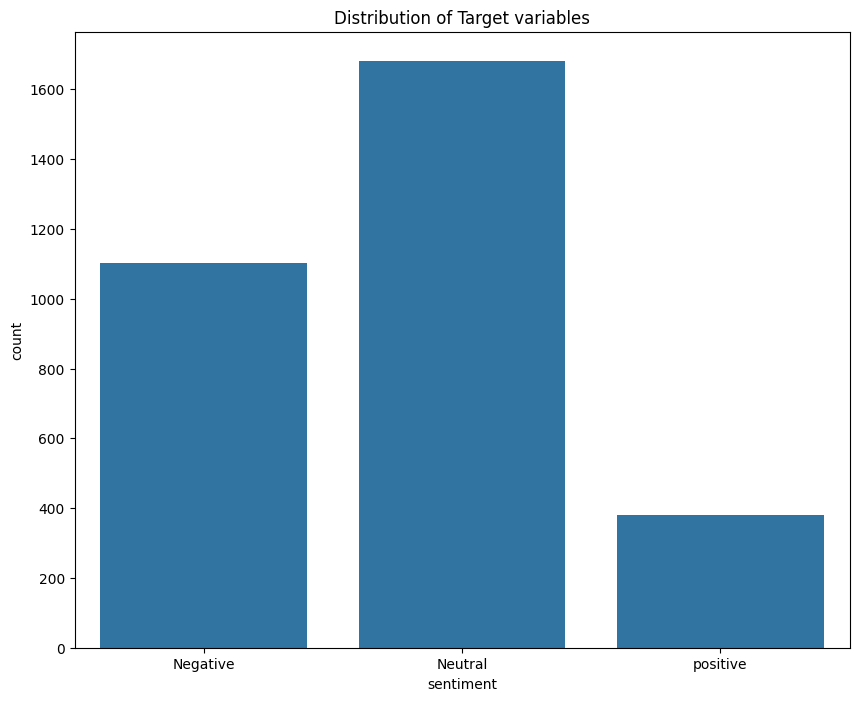

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
ax= sns.countplot(data = data, x='sentiment')
#using xtickslabels to label values 1 as negative,3 as neutral and 5 as positive
ax.set(title='Distribution of Target variables',xticklabels=['Negative','Neutral','positive']);

### Common words for the negative sentiments

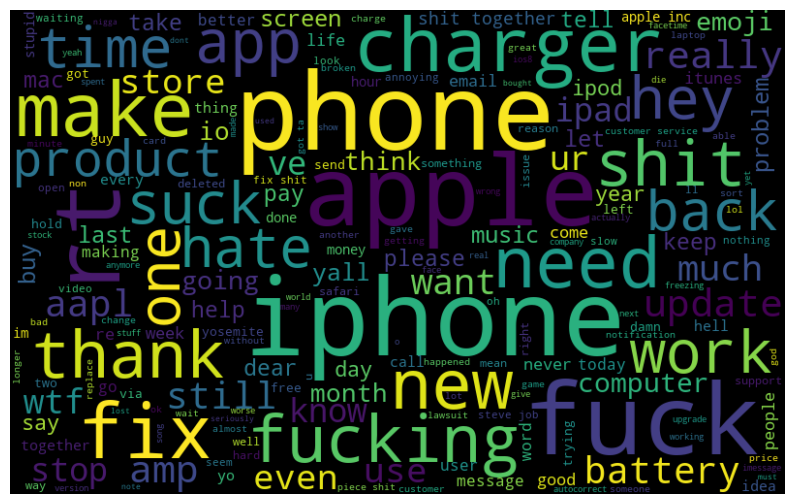

In [16]:
#Negative words
negative_words = ' '.join(data.query("sentiment==1")['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [17]:
### Create a FreqDist Keeping the 20 most common words for negative sentiments

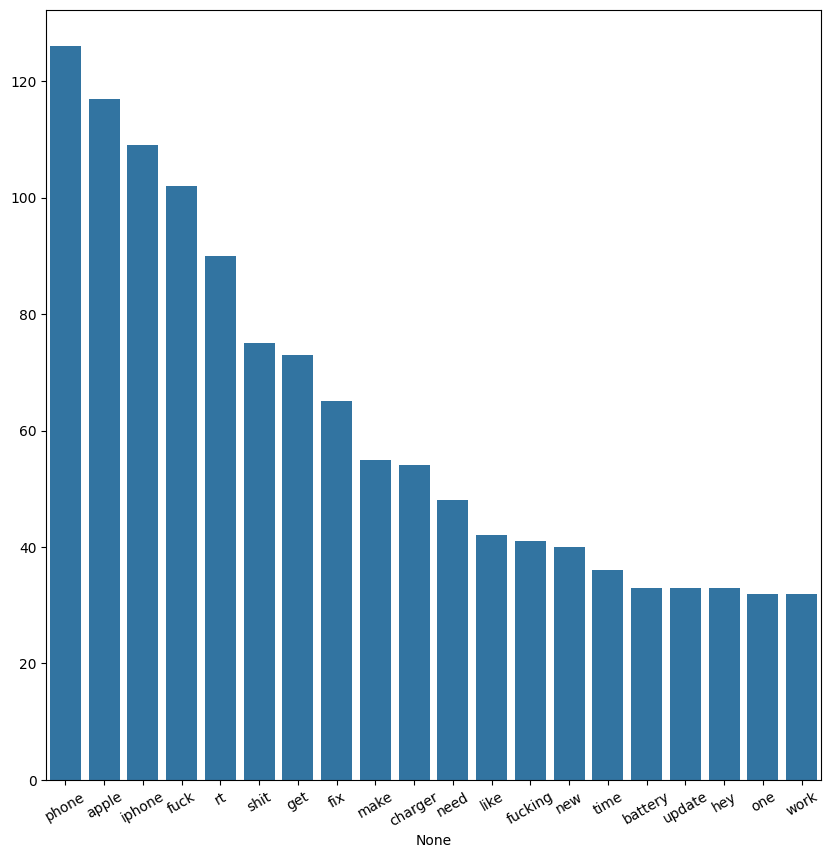

In [18]:
negative_tokens = word_tokenize(negative_words) #tokenize data
all_fdist = FreqDist(negative_tokens).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

### Common words for positive sentiments

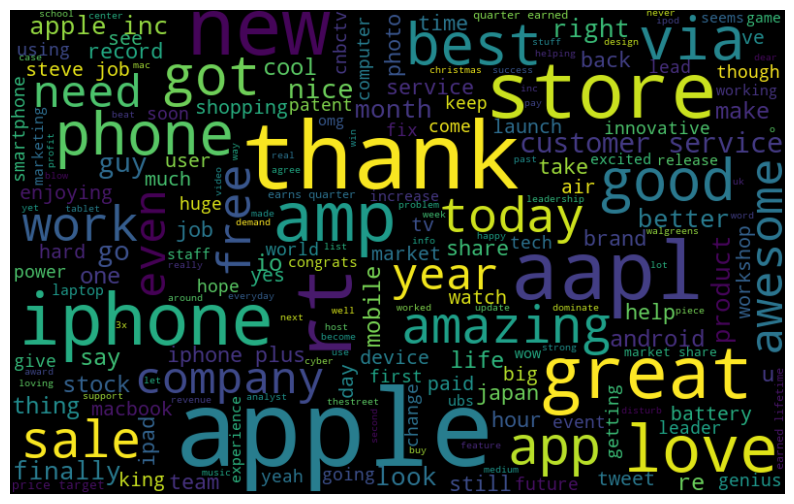

In [19]:
#positive words
positive_words = ' '.join(data.query('sentiment==5')['cleaned_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21 ,max_font_size=110).generate(positive_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off');

### Freqdist for most common 20 words for positive sentiments

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'apple'),
  Text(1, 0, 'aapl'),
  Text(2, 0, 'rt'),
  Text(3, 0, 'store'),
  Text(4, 0, 'new'),
  Text(5, 0, 'iphone'),
  Text(6, 0, 'thanks'),
  Text(7, 0, 'great'),
  Text(8, 0, 'amp'),
  Text(9, 0, 'love'),
  Text(10, 0, 'thank'),
  Text(11, 0, 'via'),
  Text(12, 0, 'good'),
  Text(13, 0, 'phone'),
  Text(14, 0, 'service'),
  Text(15, 0, 'best'),
  Text(16, 0, 'got'),
  Text(17, 0, 'like'),
  Text(18, 0, 'sale'),
  Text(19, 0, 'amazing')])

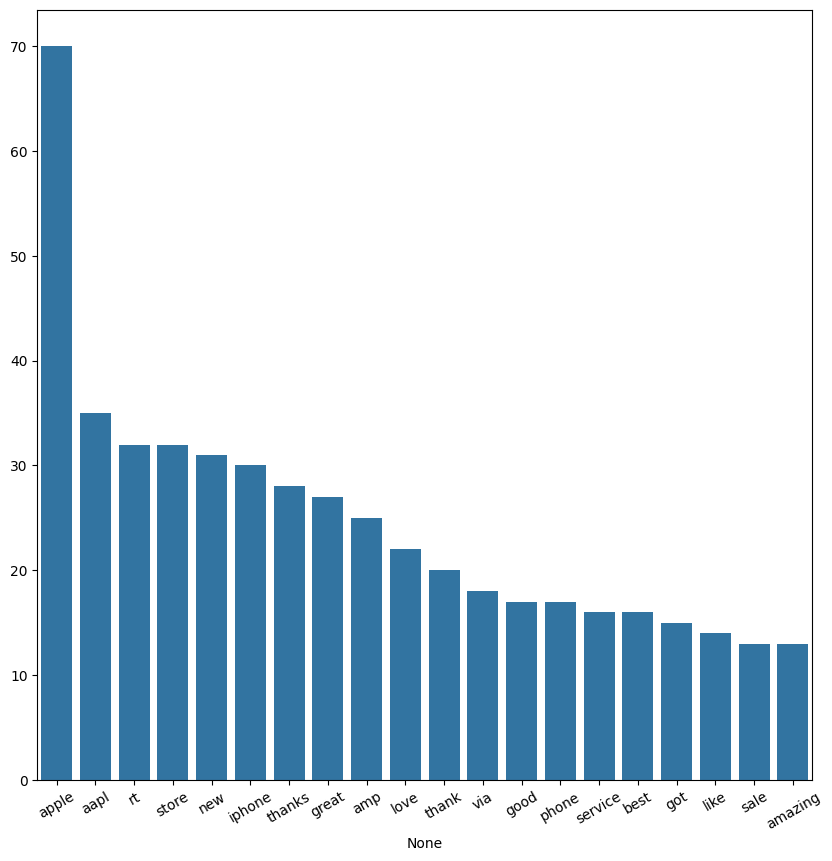

In [20]:
# 1. Tokenize and get frequency distribution of top 20 words
positive_tokens = word_tokenize(positive_words)
all_fdist = FreqDist(positive_tokens).most_common(20)

# 2. Convert to Pandas Series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# 3. Setting figure and axis into variables
fig, ax = plt.subplots(figsize=(10, 10))

# 4. Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30)

## Common words for neutral words

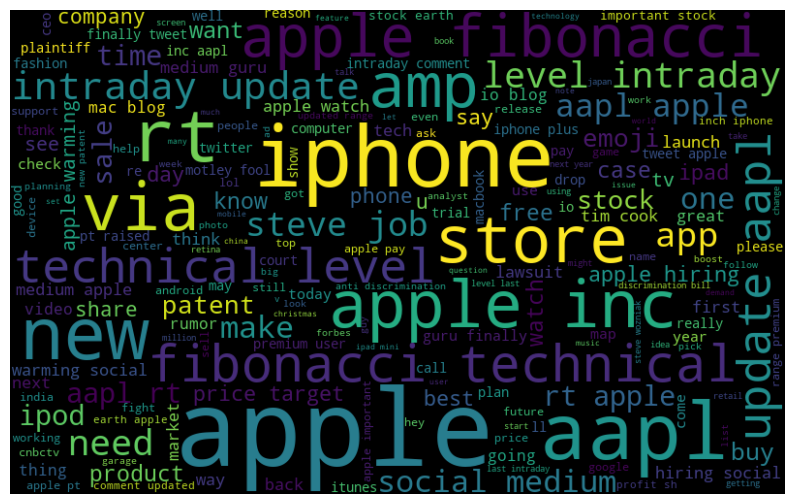

In [21]:
#neutral
neutral_words = ' '.join(data.query("sentiment==3")['cleaned_text'])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neutral_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Freqdist for most common 20 words for Neutral sentiments

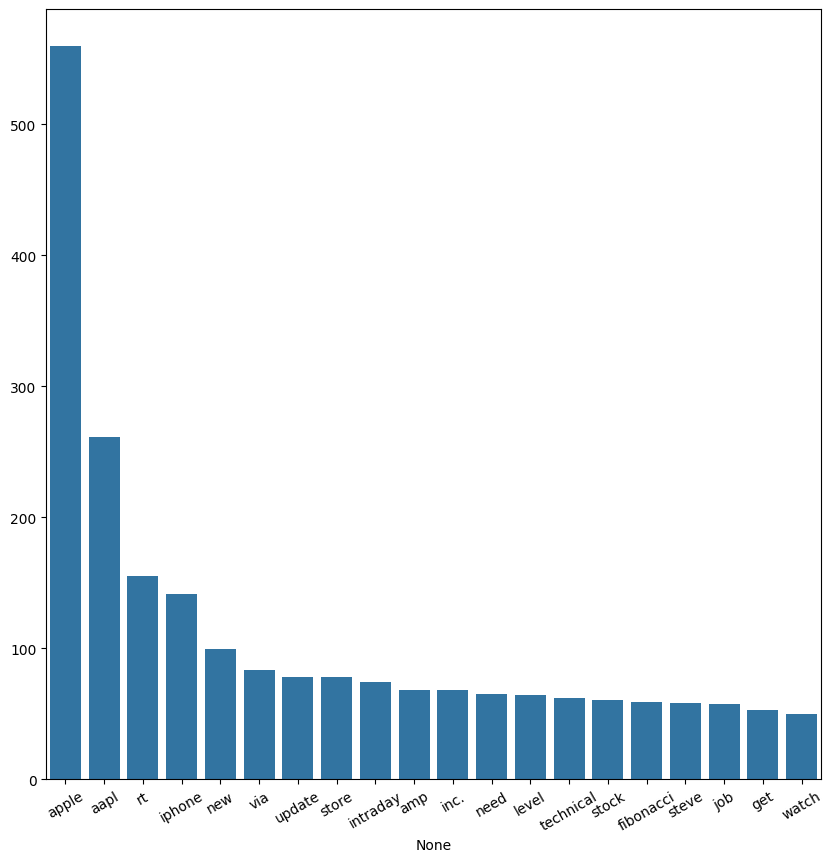

In [22]:
neutral_tokens = word_tokenize(neutral_words)
all_fdist = FreqDist(neutral_tokens).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10, 10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

# Modelling

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [24]:
#split data into x and y
X = data['cleaned_text']
y = data['sentiment']

y = le.fit_transform(y)


#split data into a training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True,random_state=42)

In [25]:
pipeline = Pipeline([
    ('tdif',TfidfVectorizer(ngram_range=(1,2))),
    ('smote',SMOTE()),
    ('model',LogisticRegression())
])

In [26]:
#Function to train the model ,make predictions and calculate evaluation metrics
def modelling(pipe):
    pipe.fit(X_train, y_train)

    # Predict train and test data
    y_hat_train = pipe.predict(X_train)
    y_hat_test = pipe.predict(X_test)

    # Get accuracy, precision, recall, and F1-score
    base_train_accuracy = accuracy_score(y_train, y_hat_train)
    base_test_accuracy = accuracy_score(y_test, y_hat_test)
    base_train_precision = precision_score(y_train, y_hat_train, average='weighted')
    base_test_precision = precision_score(y_test, y_hat_test, average='weighted')
    base_train_recall = recall_score(y_train, y_hat_train, average='weighted')
    base_test_recall = recall_score(y_test, y_hat_test, average='weighted')
    base_train_f1 = f1_score(y_train, y_hat_train, average='weighted')
    base_test_f1 = f1_score(y_test, y_hat_test, average='weighted')

    # Binarize labels for multiclass ROC curve
    classes = sorted(set(y_train))  # Get unique classes
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Get prediction scores
    if hasattr(pipe, "decision_function"):
        y_score_train = pipe.decision_function(X_train)
        y_score_test = pipe.decision_function(X_test)
    else:
        y_score_train = pipe.predict_proba(X_train)
        y_score_test = pipe.predict_proba(X_test)

    # Compute ROC curve and AUC for each class
    train_auc_list, test_auc_list = [], []
    plt.figure(figsize=(8, 6))
    
    for i in range(len(classes)):
        train_fpr, train_tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
        test_fpr, test_tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
        
        train_auc = auc(train_fpr, train_tpr)
        test_auc = auc(test_fpr, test_tpr)
        
        train_auc_list.append(train_auc)
        test_auc_list.append(test_auc)
        
        sns.lineplot(x=test_fpr, y=test_tpr, label=f'Class {classes[i]} - Test AUC: {test_auc:.4f}')
    
    # Average AUC
    avg_train_auc = sum(train_auc_list) / len(train_auc_list)
    avg_test_auc = sum(test_auc_list) / len(test_auc_list)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

    return {
        'Training Accuracy': base_train_accuracy,
        'Test Accuracy': base_test_accuracy,
#         'Training precision': base_train_precision,
        'Test precision': base_test_precision,
#         'Training recall': base_train_recall,
        'Test recall': base_test_recall,
#         'Training f1_score': base_train_f1,
        'Test f1_score': base_test_f1,
        'Average Train AUC': avg_train_auc,
        'Average Test AUC': avg_test_auc
    }

# Models Evaluation

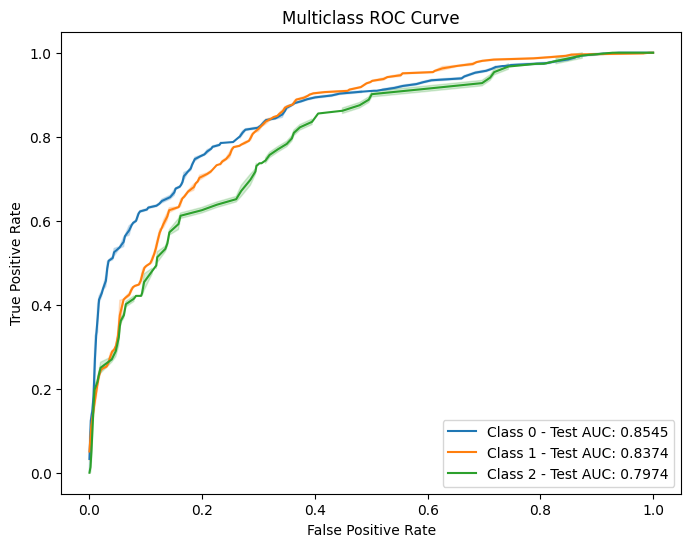

{'Training Accuracy': 0.9640173981810992,
 'Test Accuracy': 0.7093206951026856,
 'Test precision': 0.7050787979074138,
 'Test recall': 0.7093206951026856,
 'Test f1_score': 0.7069514129214481,
 'Average Train AUC': 0.9928734339501176,
 'Average Test AUC': 0.8297698717018065}

In [27]:
logreg = modelling(pipeline)
logreg

## Random Forest

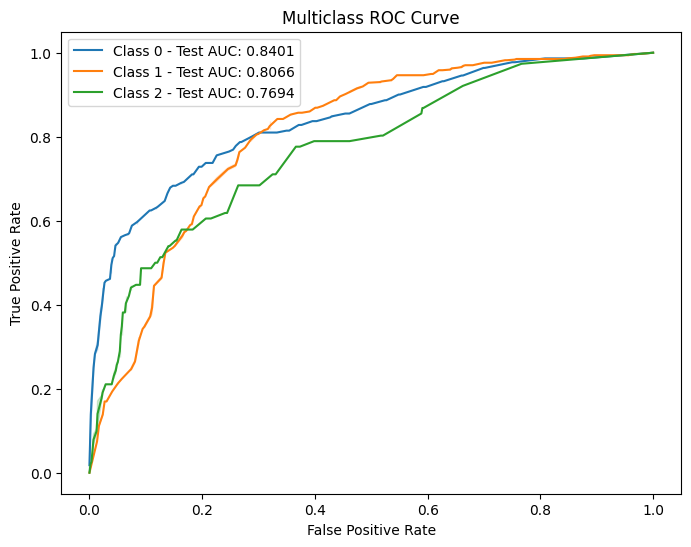

{'Training Accuracy': 0.9905100830367735,
 'Test Accuracy': 0.6966824644549763,
 'Test precision': 0.7082878401882079,
 'Test recall': 0.6966824644549763,
 'Test f1_score': 0.6711527626460908,
 'Average Train AUC': 0.9995069613009373,
 'Average Test AUC': 0.8053884606907656}

In [28]:
pipeline.set_params(model=RandomForestClassifier(random_state=42))
rdf = modelling(pipeline)
rdf

#### multinomial naive bayes

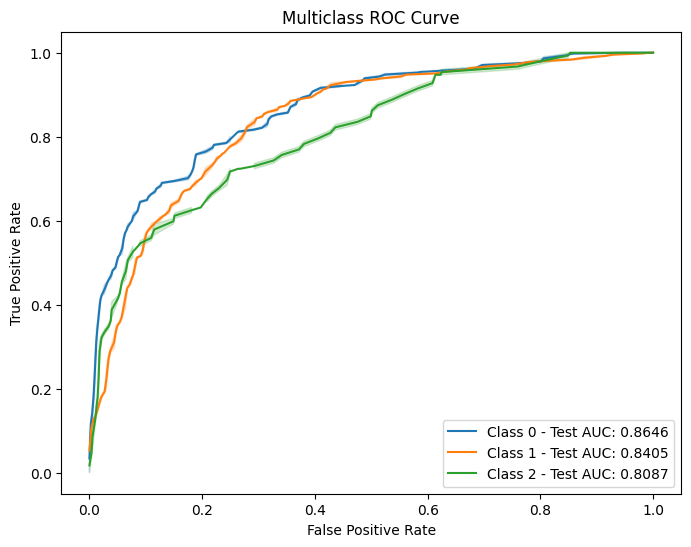

{'Training Accuracy': 0.9414788453934362,
 'Test Accuracy': 0.6856240126382307,
 'Test precision': 0.7097882308937807,
 'Test recall': 0.6856240126382307,
 'Test f1_score': 0.6920255156083023,
 'Average Train AUC': 0.9880879618674964,
 'Average Test AUC': 0.8379264906068938}

In [29]:
pipeline.set_params(model = MultinomialNB())
nb =  modelling(pipeline)
nb

## Decision tree

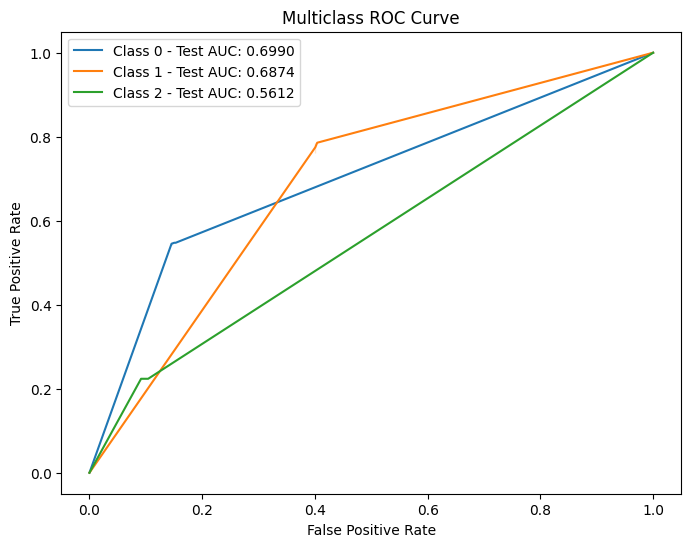

{'Training Accuracy': 0.9905100830367735,
 'Test Accuracy': 0.6334913112164297,
 'Test precision': 0.6263120473808,
 'Test recall': 0.6334913112164297,
 'Test f1_score': 0.6263444713910812,
 'Average Train AUC': 0.999875920488633,
 'Average Test AUC': 0.6491786766375355}

In [30]:
pipeline.set_params(model = DecisionTreeClassifier(random_state=42))
dt = modelling(pipeline)
dt

## Support Vector Machines

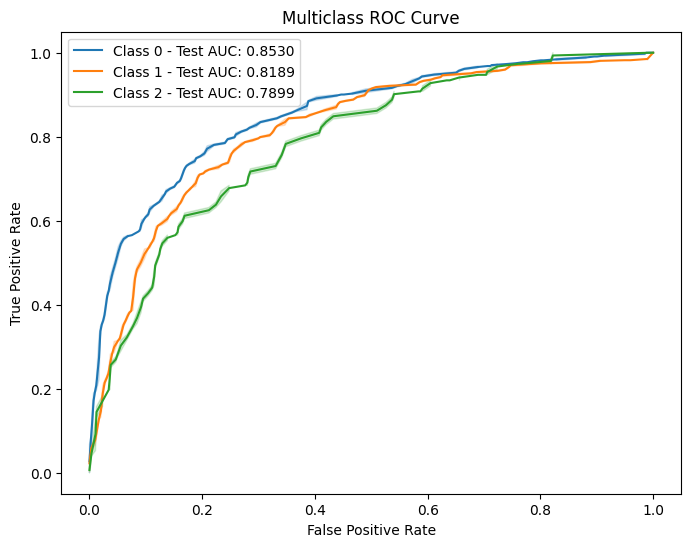

{'Training Accuracy': 0.9802293396599446,
 'Test Accuracy': 0.7030015797788309,
 'Test precision': 0.6905641196597694,
 'Test recall': 0.7030015797788309,
 'Test f1_score': 0.6817595237523302,
 'Average Train AUC': 0.9955458445690003,
 'Average Test AUC': 0.8206030065918446}

In [31]:
pipeline.set_params(model = svm.SVC())
svm = modelling(pipeline)
svm

## XGBoost

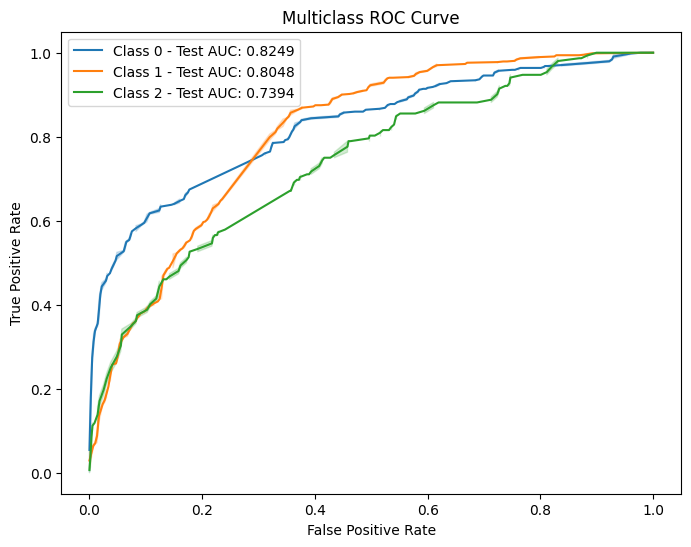

{'Training Accuracy': 0.8936338473705022,
 'Test Accuracy': 0.6998420221169036,
 'Test precision': 0.7049743856816196,
 'Test recall': 0.6998420221169036,
 'Test f1_score': 0.6813049681120864,
 'Average Train AUC': 0.9724723370196461,
 'Average Test AUC': 0.7897079054728723}

In [32]:
pipeline.set_params(model = XGBClassifier())
xgb = modelling(pipeline)
xgb

## Store Model results into a dataframe

In [33]:
# Dictionary of model results
model_results = {
    "Logistic Regression": logreg,
    "Random Forest": rdf,
    "Naïve Bayes":nb,
    "Decision Tree": dt,
    "SVM": svm,
    "XGBoost": xgb,
}

# Convert dictionary to DataFrame
df_results = pd.DataFrame.from_dict(model_results, orient='index')

# Display the DataFrame
df_results

,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score,Average Train AUC,Average Test AUC
Logistic Regression,0.964017,0.709321,0.705079,0.709321,0.706951,0.992873,0.829770
Random Forest,0.990510,0.696682,0.708288,0.696682,0.671153,0.999507,0.805388
Naïve Bayes,0.941479,0.685624,0.709788,0.685624,0.692026,0.988088,0.837926
Decision Tree,0.990510,0.633491,0.626312,0.633491,0.626344,0.999876,0.649179
SVM,0.980229,0.703002,0.690564,0.703002,0.681760,0.995546,0.820603
XGBoost,0.893634,0.699842,0.704974,0.699842,0.681305,0.972472,0.789708


### Check Difference between train and test accuracy

In [34]:
df_results['Training Accuracy'] - df_results['Test Accuracy']

Logistic Regression    0.254697
Random Forest          0.293828
Naïve Bayes            0.255855
Decision Tree          0.357019
SVM                    0.277228
XGBoost                0.193792
dtype: float64

# Hyperparameter tuning

In [35]:
param_grid = {
    'model__n_estimators': [100, 300, 500],  
    'model__max_depth': [3, 5, 7],  
    'model__learning_rate': [ 0.1, 0.2,0.4],  
    'model__subsample': [0.7, 0.8, 1.0],  
    'model__colsample_bytree': [0.7, 0.8, 1.0],  
    'model__gamma': [0, 0.1, 0.2]  
}

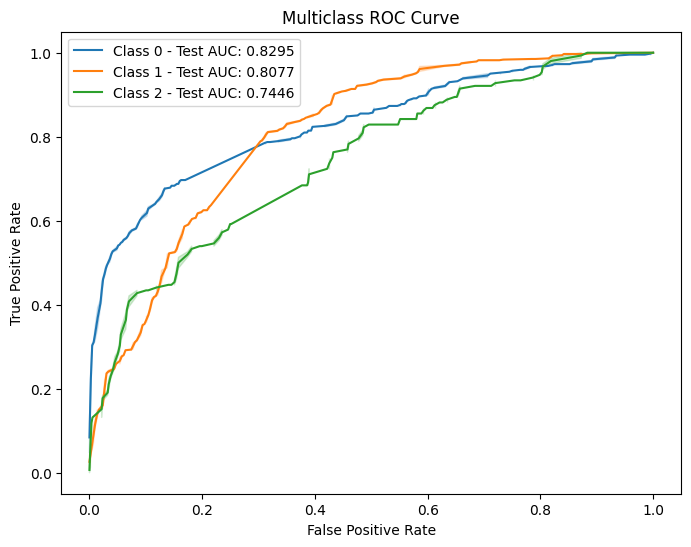

{'Training Accuracy': 0.8908659549228944,
 'Test Accuracy': 0.7061611374407583,
 'Test precision': 0.7144175354998054,
 'Test recall': 0.7061611374407583,
 'Test f1_score': 0.6873482938313729,
 'Average Train AUC': 0.9721954949535805,
 'Average Test AUC': 0.7939357254268881}

In [36]:
xgb_tuned = modelling(pipeline)
xgb_tuned

In [37]:
pipeline.set_params(model = LogisticRegression())
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__penalty': ['l1', 'l2'],  # Type of regularization
    'model__solver': ['liblinear']  # Required for L1 penalty
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best accuracy Score:", grid.best_score_)

Best Parameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best accuracy Score: 0.7022643133878604


C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


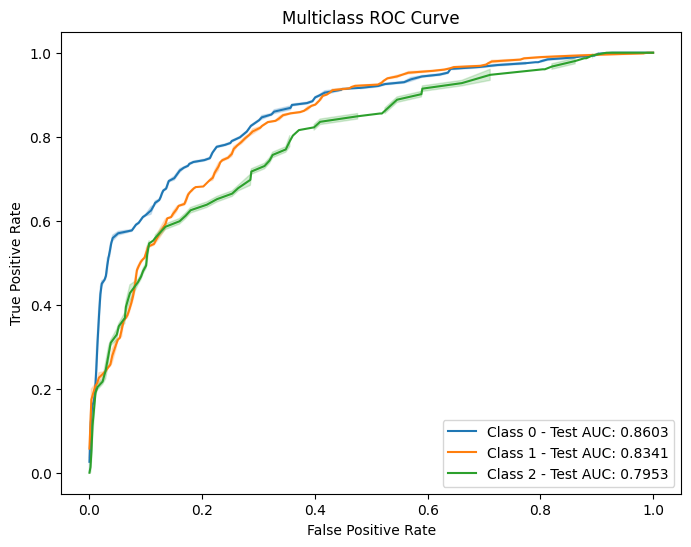

{'Training Accuracy': 0.9826018189007513,
 'Test Accuracy': 0.7140600315955766,
 'Test precision': 0.7120692468090839,
 'Test recall': 0.7140600315955766,
 'Test f1_score': 0.7129854355333215,
 'Average Train AUC': 0.9983990410252511,
 'Average Test AUC': 0.8298915449625929}

In [38]:
pipeline.set_params(model = LogisticRegression(
                                              C= 10,
                                             penalty = 'l2',
                                             solver = 'liblinear'
))
logistic_tuned= modelling(pipeline)
logistic_tuned

In [39]:
model_results = {
    "Logistic Regression_tuned": logistic_tuned,
    "XGBoost_tuned": xgb_tuned,
}

# Convert dictionary to DataFrame
df_results_tuned = pd.DataFrame.from_dict(model_results, orient='index')

# Display the DataFrame
df_results_tuned

,Training Accuracy,Test Accuracy,Test precision,Test recall,Test f1_score,Average Train AUC,Average Test AUC
Logistic Regression_tuned,0.982602,0.714060,0.712069,0.714060,0.712985,0.998399,0.829892
XGBoost_tuned,0.890866,0.706161,0.714418,0.706161,0.687348,0.972195,0.793936


# Make predictions

In [40]:
#create function to predict sentiment
pipeline.set_params(model =  LogisticRegression(
                                              C= 10,
                                             penalty = 'l2',
                                             solver = 'liblinear'))
pipeline.fit(X_train,y_train)
def sentiment_check(tweet):
    tweet_processed = clean_text(tweet)
    print(f'tweet:{tweet_processed}')
    prediction = pipeline.predict([tweet_processed])
    return "Negative Statement" if prediction[0] == 1 else "Neutral Statemnet" if prediction[0]==3 else "Positive statement" if prediction[0]==5 else "not_relevant"

print(sentiment_check('this phones suck,its not what is marketed'))

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


tweet:phone suck marketed
not_relevant
